In [1]:
import sys
sys.path.append("/home/timbo/extrepos/julian_repos")

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [2]:
#
# Derive the polygons from the network of nodes in UV space ( --> XYZ space by function wingshape.seval )
#
from barmesh.basicgeo import I1, Partition1

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [3]:
#
# We need to identify and number the polygons (and some of the edges) appropriately 
# So that we can make the differential offsetting of them
#


In [4]:
#
# Calculate the offsets of the polygons
#

radoffset = 0.006

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour
#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1


def barmeshoffset(polyloop, polyloopW, radoffset, uspacing, vspacing):
    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop)
    
    #
    # should derive these from a single partition that is subselected
    #
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = Partition1(urg.lo, urg.hi, int(urg.Leng()/uspacing + 2))
    ypart = Partition1(vrg.lo, vrg.hi, int(vrg.Leng()/vspacing + 2))

    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()
    return bm

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    surfacemesh["barmeshoffset"] = barmeshoffset(polyloop, polyloopW, radoffset=radoffset, uspacing=0.02, vspacing=0.02)



Starting 0
make triangle boxing at 0.047043302883781335
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 3040 nodes
do splitbarsdirectionchangesR on 5953 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  230
nsegs: 253 bad: 0 working: 0
111 [15, 10, 25, 0, 15, 6, 20, 0, 10, 10, 0, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.04245011031816404
make triangle boxing at 0.06165027625633657
MakePointZoneRFS done on 5244 nodes
do splitbarsdirectionchangesR on 10237 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  482
nsegs: 498 bad: 0 working: 0
76 [15, 15, 10, 5, 10, 3, 8, 0, 5, 5, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.052358552582613564
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 1696 nodes
do splitbarsdirectionchangesR on 3307 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  146
nsegs: 169 bad: 0 working: 0
111 [15, 10, 25, 0, 15, 6, 20, 0, 10, 10, 0, 0, 0, 0, 0]

Starting 3
ma

In [5]:
from barmesh import barmesh
from wingflatten_barmeshfuncs import findallnodesandpolys, cpolytriangulate

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    surfacemesh["offsettopbar"] = topbars[0]
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]

    tnodes, cpolys = findallnodesandpolys(bm)
    ptsF = [ node.sp  for node in tnodes ]
    surfacemesh["pts"] = numpy.array([ node.p  for node in tnodes ])
    surfacemesh["uvpts"] = numpy.array(ptsF)
    tris = [ ]
    for cpoly in cpolys:
        tris.extend(cpolytriangulate(ptsF, cpoly))
    surfacemesh["tris"] = numpy.array(tris)
    surfacemesh["offsetloopI"] = [n.i for n in outercont]
    print(i, len(ptsF), len(tris))


0 2588 4921
1 4308 8116
2 1412 2653
3 12386 24200
4 1184 2215
5 7185 13926
6 4906 9105
7 761 1400
8 1550 2923
9 4927 9552
10 704 1290
11 704 1290
12 1723 3216
13 732 1344
14 2382 4556
15 2282 4360


In [6]:
#
# Call the surface flattener (produces surfacemesh["fpts"], "triareas", "ftriareas")
#

#freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"

from parapolygraph import trimeshesflattener
trimeshesflattener(surfacemeshes, freecadappimage)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> >>> 


[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=2588, tris=4921) flattened
mesh (pts=4308, tris=8116) flattened
mesh (pts=1412, tris=2653) flattened
mesh (pts=12386, tris=24200) flattened
mesh (pts=1184, tris=2215) flattened
mesh (pts=7185, tris=13926) flattened
mesh (pts=4906, tris=9105) flattened
mesh (pts=761, tris=1400) flattened
mesh (pts=1550, tris=2923) flattened
mesh (pts=4927, tris=9552) flattened
mesh (pts=704, tris=1290) flattened
mesh (pts=704, tris=1290) flattened
mesh (pts=1723, tris=3216) flattened
mesh (pts=732, tris=1344) flattened
mesh (pts=2382, tris=4556) flattened
mesh (pts=2282, tris=4360) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



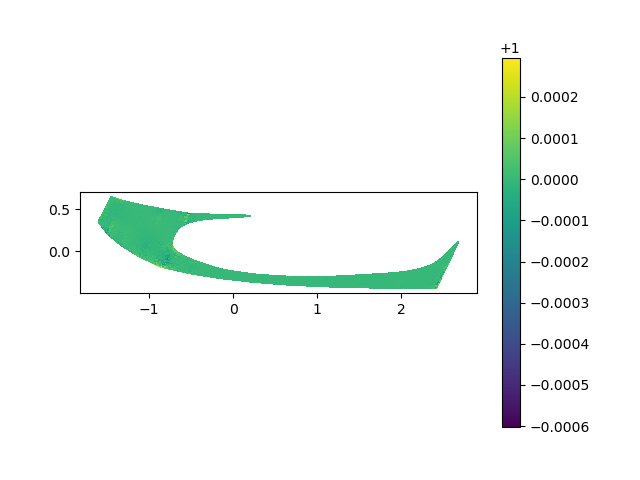

In [7]:
%matplotlib widget

from matplotlib import pyplot as plt

surfacemesh = surfacemeshes[6]
fpts = surfacemesh["fpts"]
X = fpts[:,0]
Y = fpts[:,1]
    
areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange)
    
plt.gca().set_aspect("equal")
plt.colorbar()


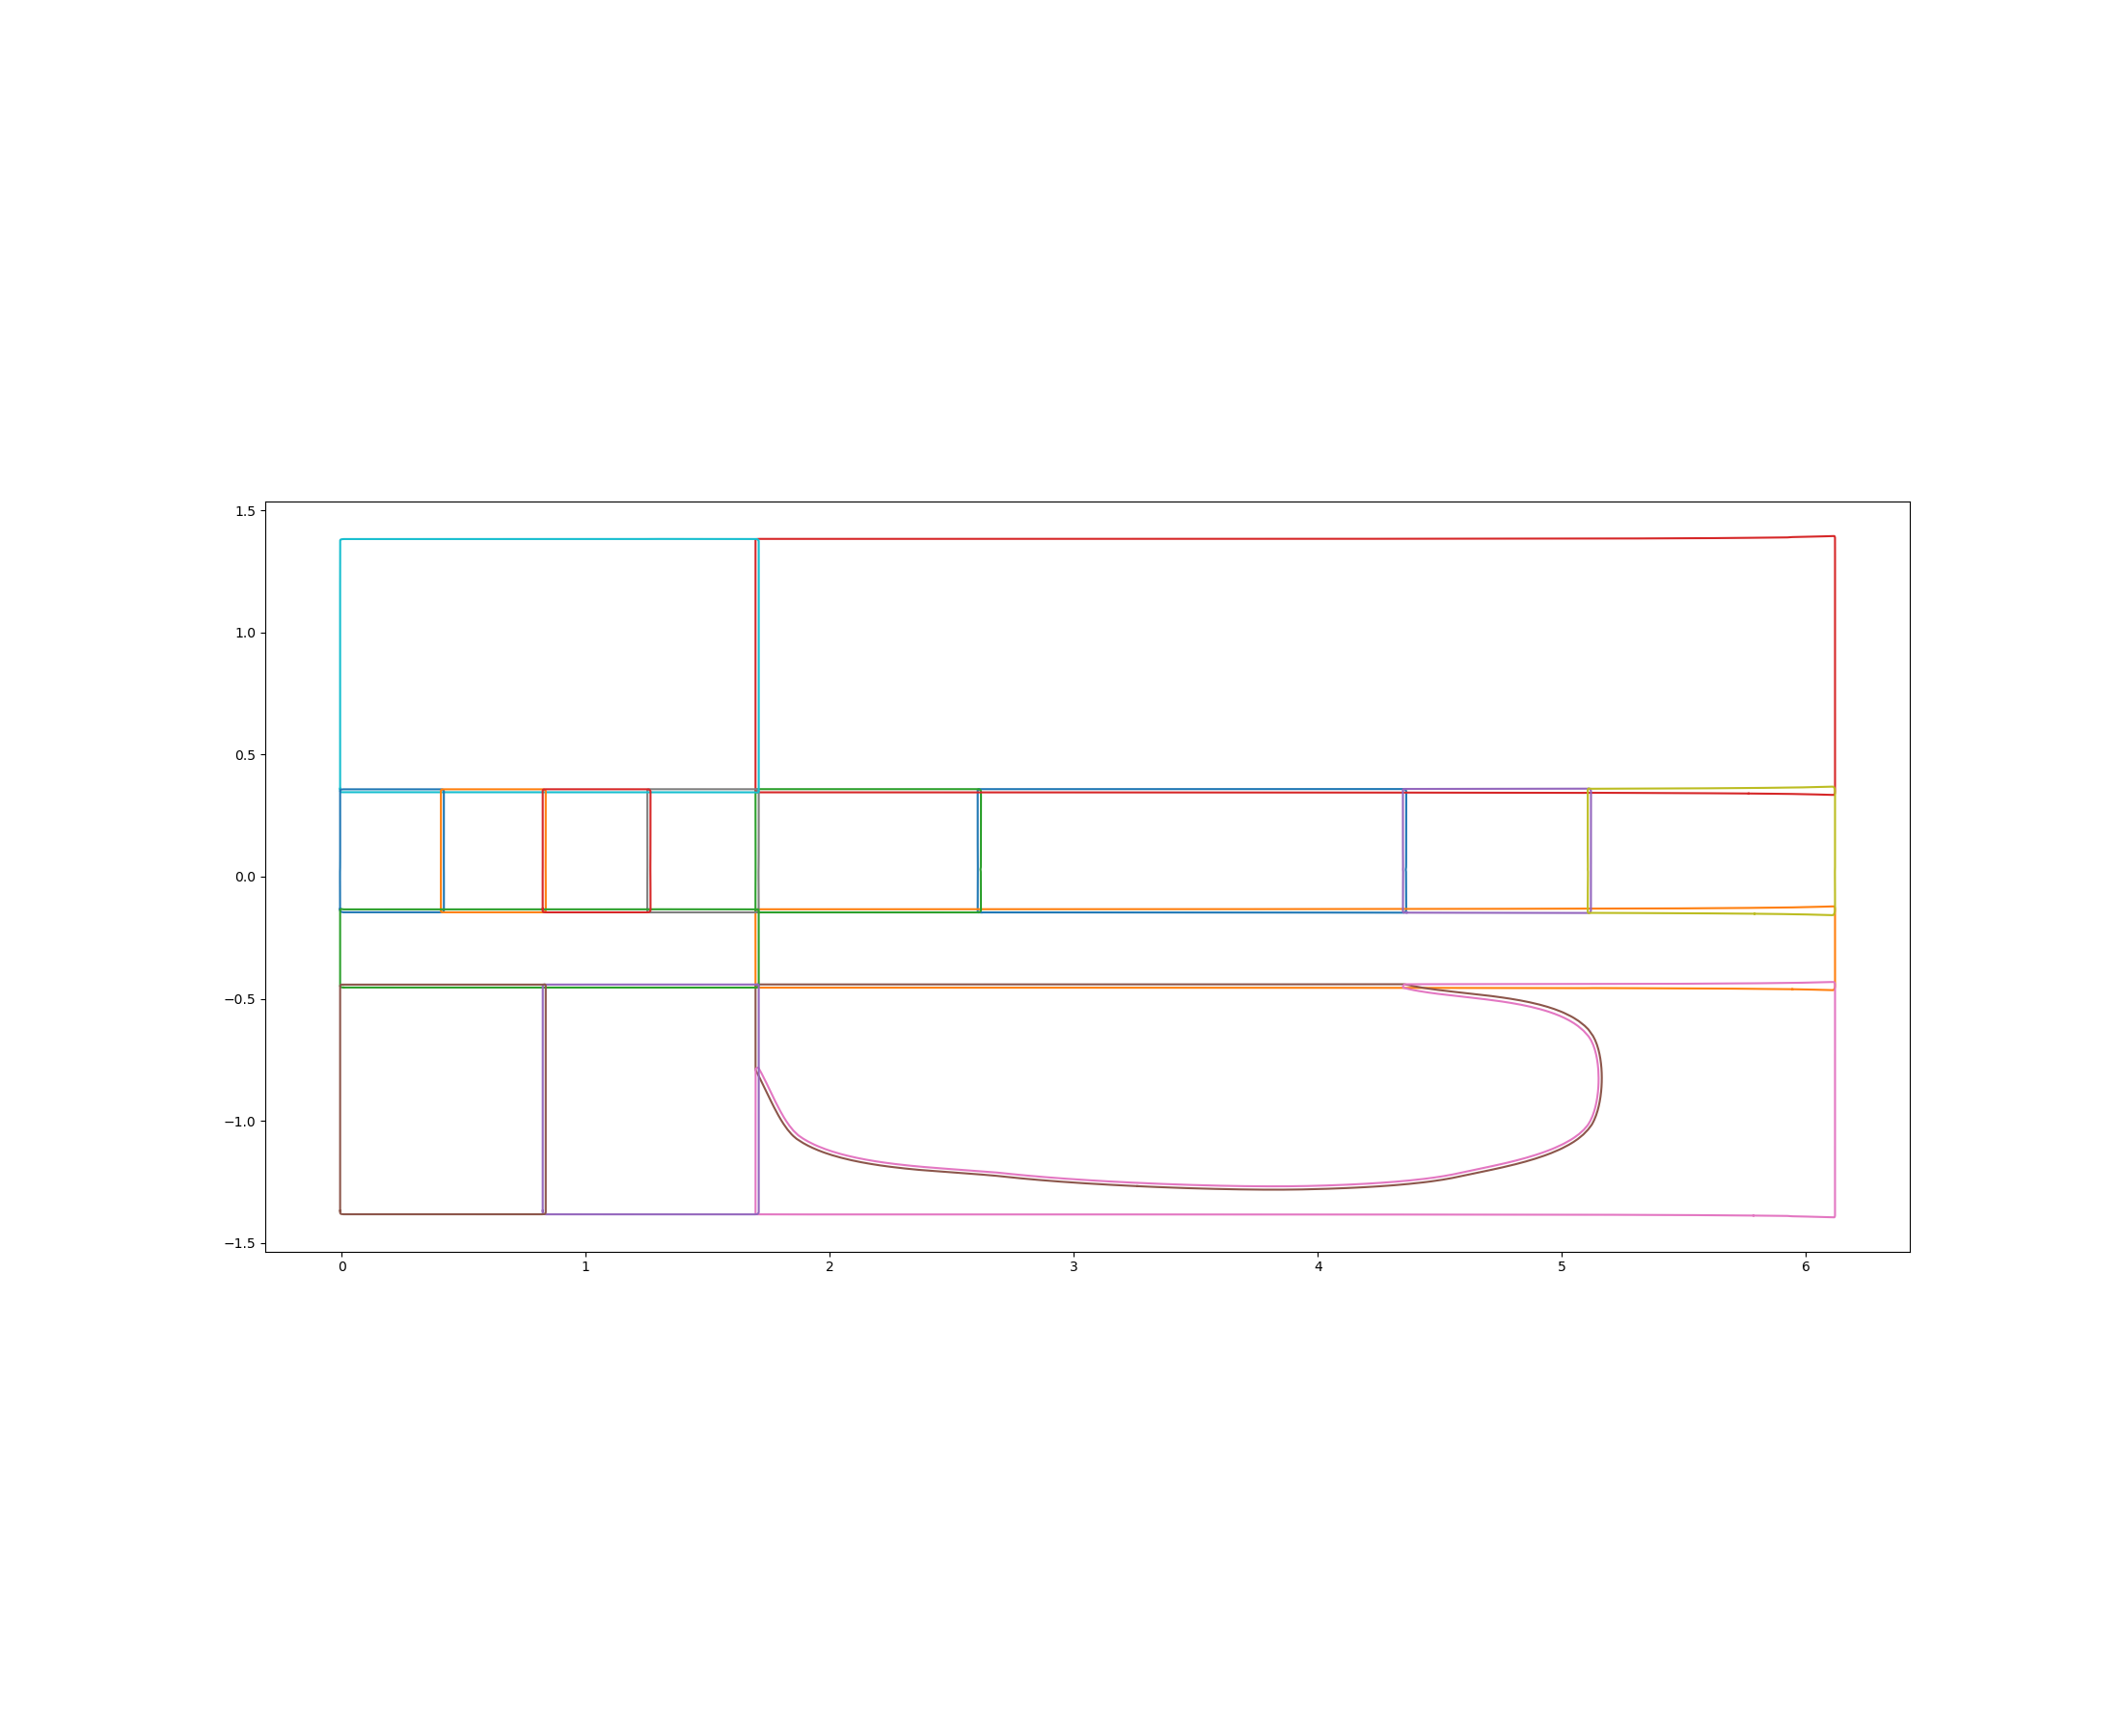

In [8]:
%matplotlib widget 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(22,18))
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
plt.gca().autoscale()
plt.gca().set_aspect("equal")


<IPython.core.display.Javascript object>


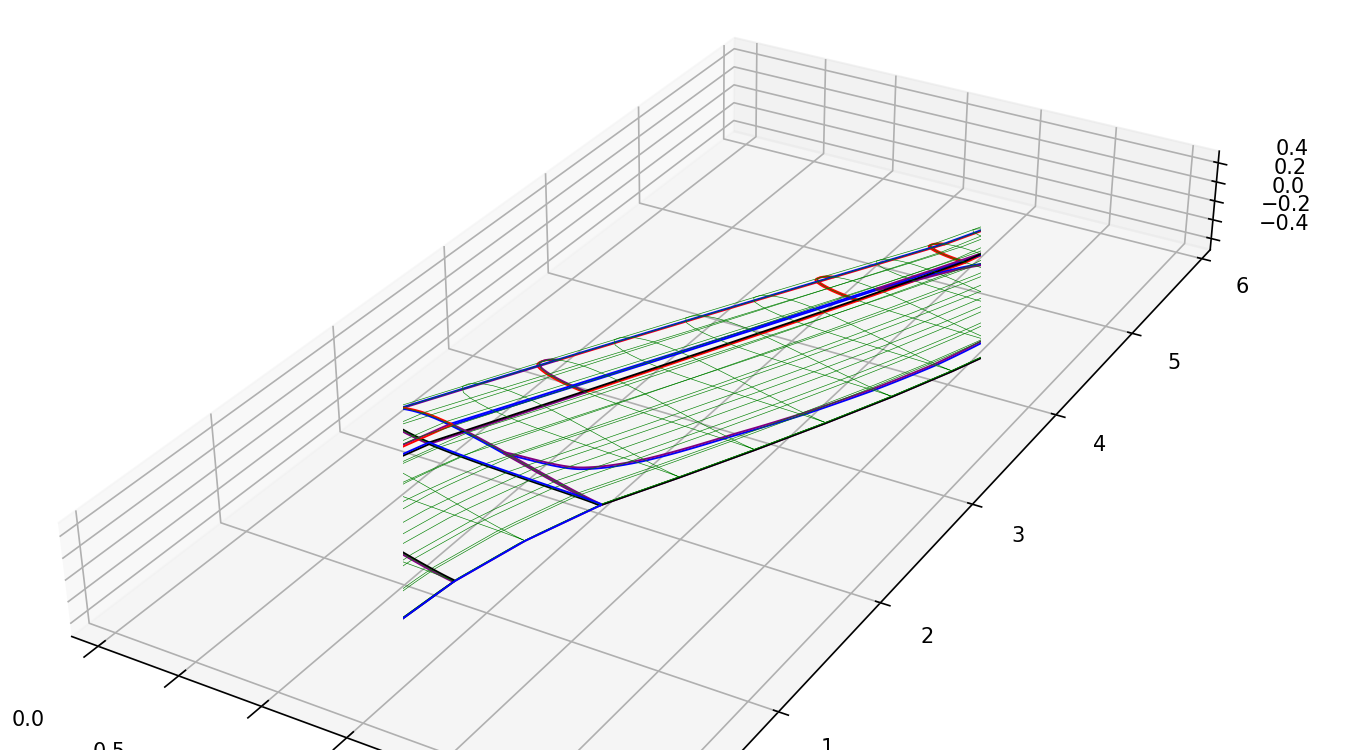

(0.0, 6.0)

In [21]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)